# The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2019 Semester 1
-----
## Project 1: Gaining Information about Naive Bayes
-----
###### Student Name(s): Syed Ahammad Newaz Saif
###### Python version: 3.7
###### Submission deadline: 1pm, Fri 5 Apr 2019 extension given till Tues 9 Apr 2019

This iPython notebook is a template which you may use for your Project 1 submission. (You are not required to use it; in particular, there is no need to use iPython if you do not like it.)

Marking will be applied on the five functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

In [1]:
## Project 1: Gaining Information about Naive Bayes 
# Subject: COMP30027 Machine Learning, 2019 Semester 1
# Authors: Syed Ahammad Newaz Saif
# Student ID : 684933
# Run with Python 3.7

In [2]:
# List of all the dictionaries necessary for the program to run

import csv
import os
import glob
import math
import random
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from math import log
from itertools import chain
from random import randrange
from collections import Counter
from operator import itemgetter
from collections import defaultdict
from collections import OrderedDict

In [3]:
def preprocessing(file):
    
    """ 
        Synopsis : This function opens a data file in csv, and returns
                   back the list of lines to a cleaning function(cleanup). 
                   We assumed there are no headers given. 
        
        Argument : The entire dataset - type : string
        
        Return value: list of list of strings - type: 2d list
    
    """
    
    lines = []
    
    with open(file) as csv_file: # opens csv files
        csv_reader = csv.reader(csv_file,delimiter = ",") # reads
        for row in csv_reader:
            lines.append(row) # adds all rows
      
    return cleanup(lines)

In [4]:
def cleanup(data):
    
    """ 
        Synopsis : This function fixes the issue of the missing values 
                   by replacing the noisy data (works on constant form of noises, here '?').
                   This function uses the replace by most common instance for a given 
                   attribute and transposes back into original form.
        
        Argument : extracted list of rows of the dataset from preprocessing - type : 2d list
        
        Return value : list of list of strings - type: 2d list
    
    """
    cleansed_data = []
    
    for column in zip(*data):
        
        counts = Counter(column)
        
        #remove the noises by Nones and then the most common instance of the attribute 
        counts.pop('?', None)
        most = counts.most_common(1)[0][0]
        fresh_cols = [most if i == "?" else i for i in column]
        
        #keep the columnwise list
        cleansed_data.append(fresh_cols)

    return list(map(list,zip(*cleansed_data))) #transpose back again to original form

In [5]:
# This function should build a supervised NB model
def train(train_data):
    
    """ 
        Synopsis : This function trains the dataset based on the supervised Naive 
                   Bayesian Modelling, counting the prior probabilities mapping it to 
                   the classes and counting the posterior probabilities mapping it to 
                   the classes and attribute numbers.  
        
        Argument : Cleaned up dataset  - type : 2d list
        
        Return values : Tuple of prior probability dictionary and posterior probability 
                      dictionary        - type: default dict of integers, 
                                                3d default dict of integers
    
    """
    
    # prior probability default dictionary of probability values and posterior probability 
    # 3d default dictionary of probability values.
    prior_dict = defaultdict(int)
    posterior_dict = defaultdict(lambda:defaultdict(lambda:(defaultdict(int))))
    
    for line in train_data:
        prior_dict[line[-1]] += 1/len(train_data) # the map of class to its probabilities calculated
    
    for line in train_data:
        attributes, class_labels = line[:-1],line[-1] # separate attributes and the labels
        
        for attribute, frequency_count in enumerate(attributes): # lists out all the column numbers
            # counts the frequency of each instance as a map of the form - class : col : instance : frequency
            posterior_dict[class_labels][attribute][frequency_count]+=1 
    
    for class_labels in posterior_dict:
        for attribute in posterior_dict[class_labels]:
            #grab the total sum of the frequencies in the given attribute column
            sums= sum(posterior_dict[class_labels][attribute].values())
            
            for frequency_count in posterior_dict[class_labels][attribute]:
                # for every instance the probability then replaced with the frequency
                posterior_dict[class_labels][attribute][frequency_count] /= sums
    
    
    return prior_dict, posterior_dict

In [6]:
# This function should predict the class for an instance or a set of instances, based on a trained model 
def predict(prior_dict,posterior_dict,instance):
    
    """ 
        Synopsis : This function predicts the trained data using Naive Bayesian model.
                   It adds some tuning with data using k-smoothing technique and returns 
                   prediction for a given instance.
        
        Arguments : Map of class : prior probability ; 
                    Map of class : column : instance : posterior probability ; 
                    Instance to predict as list 
                                                    - type : default dict of integers, 
                                                             3d default dict of integers,
                                                             list
        
        Return value : Predicted class               - type: string
    
    """
    
    class_max = {}
    EPSILON = 0.00000000001 # smoothing
    
    for class_name in posterior_dict:
        product = 1
        
        for i,j in zip(posterior_dict[class_name],instance): # maps the instances and the columns
            
            probability = posterior_dict[class_name][i][j]
            
            if(probability > 0):
                product*= probability
            else:
                #product  = ksmoothing(product) for enhancing the code
                product*= EPSILON
                
        class_max[class_name] = log(product) + log(prior_dict[class_name]) # log(posterior probabilities) + log (prior probabilities)
    
    return max(class_max.items(),key = itemgetter(1)) # maximum of the probability and class as a tuple used to find the maximal probabilitistic class

In [7]:
def make_confusion_matrix(correct,guess):
    
    """ 
        Synopsis : This function creates a heatmap of the confusion matrix.
        
        Arguments : List of correct frequencies for the instances; List of guessed 
                    frequencies for the instances  - type : list, list
        
        Return value : None
    
    """
    
    y_actu = pd.Series(correct, name='Actual') # creates a series of correct counts 
    y_pred = pd.Series(guess, name='Predicted') # creates a series of guess counts
    
    # creates a confusion matrix of the actual and predicted values
    df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    df_conf_norm = df_confusion / df_confusion.sum(axis=1) #normalise it
    df_conf_norm = df_conf_norm.fillna(0) #takes account of NANs
    sn.heatmap(df_conf_norm, cmap='Oranges', annot=True) # form a heatmap display
    plt.show() 

In [8]:
def evaluate(posterior_prob, prior_prob, train_data):
    
    """
        Synopsis : This function evaluates a set of predictions, in a supervised context.
                   It uses the predict function to come with the predictions of each instances 
                   and the probability of correctness are fetched.
    
        Argument : Map of class : column : instance : posterior probability; 
                   Map of class : prior probability ; 
                   Training data               - type : 3d default dict of integers,
                                                        default dict of integers, float
    
        Return value : Probability of correctness    - type : float
    """
    
    correct = 0
    guesses = []
    matches = []
    
    for instance in train_data:
        predicted_value,_  =  predict(posterior_prob, prior_prob, instance)
        if(predicted_value == instance[-1]):
            #predicted value equal to the class label
            correct+=1
        matches.append(instance[-1]) # collect all matches
        guesses.append(predicted_value) # collect all guesses
    
    # output a confusion matrix
    make_confusion_matrix(matches,guesses)
    
    return correct/len(train_data)

In [9]:
def entropy(probability):
    
    """
        Synopsis : This function takes a probability and returns the entropy value. 
    
        Argument : Probability  - type : float
    
        Return value : Entropy value  - type : float
    """
    
    return -probability*math.log2(probability)

In [10]:
def holdout(data,split_size):
    
    """
        Synopsis: This function performs holdout split evaluation strategy on the 
                  given dataset. It shuffles data and splits by random maintain 
                  split size ratio of train to test. Returns new accuracy. 
    
        Arguments: The entire dataset, Split ratio  - type : 2d list, float
    
        Return value : Evaluated score              - type : float
    """
    
    training_data  = []
    
    random.shuffle(data)  # shuffle to avoid biasness in data
    
    train_data_len = int(split_size*len(data)) # split size noted
    
    dataset_copy = data
    
    while(len(training_data) < train_data_len):
        
        # different instances classified as train or test overall the ratio of test to train maintained
        index = randrange(len(dataset_copy))
        
        # the dataset then stored
        training_data.append(dataset_copy.pop(index)) 
    
    priors, posteriers = train(training_data) # trained
    
    return evaluate(priors, posteriers, dataset_copy) # evaluation performed

In [11]:
def cross_validation(data, k):
    
    """
        Synopsis : This function performs cross validation on a dataset.It then
                  splits dataset into k partitions,then chooses one section to 
                  be the training data, and the rest as the test data. This is 
                  performed k times. Returns new accuracy. 
    
        Arguments : The entire dataset, number of partitions for the data to split 
                    into                          - type : 2d list, integer
    
        Return value : total sum of all evaluations for all data divided by partitions
                                                 - type : float
    """
    
    # divide dataset into k length partitions
    partitions = [part.tolist() for part in np.array_split(data, k)]

    # handy lambda function that facilitates 
    flatten = lambda lst : list(chain.from_iterable(lst))

    # accuracy counter
    sums = 0

    for i, test_data in enumerate(partitions):

        # as the array appears to be in list of list of list 
        # we need to flatten the sections to concatenate list
        # attaining the partitions without using the current test data
        
        training_data = flatten(partitions[:i]) + flatten(partitions[i+1:])

        # get the trained supervised model for and using prior and 
        # posterior probabilities for evaluation in the coming steps
        
        priors, posteriers = train(training_data)

        # accumulate accuracy of test data
        sums += evaluate(priors, posteriers, test_data)

    return sums/k

In [12]:
def group_data_by_cols(data):
    
    """ 
        Synopsis : This function takes the dataset and creates a dictionary of column to 
                   instance probabilities as a list where each probability corresponds to 
                   a given class.  
        
        Argument : The entire dataset.   - type : 2d list
        
        Return value : The mapped dictionary of column : instance : list of 
                      probabilities(each corresponding ordered mapping to a class).
                                        - type: default_dict
    
    """

    posterior_dict = defaultdict(lambda:defaultdict(lambda:(defaultdict(int)))) 
    
    for line in data:
        attributes, class_labels = line[:-1],line[-1] #separate labels and classes
        
        for attribute, frequency_count in enumerate(attributes):
            posterior_dict[class_labels][attribute][frequency_count]+=1 # make the similar frequency dictionary
            
    new_dict =  defaultdict((lambda:(defaultdict(list))))       
    for class_labels in posterior_dict:
        for x,y in posterior_dict[class_labels].items(): # go through a particular row
            for x1,y1 in y.items(): # access labels and values
                new_dict[x][x1].append(y1) # for a given row make a list of the frequency of the instances for each class
        
    for class_labels in new_dict:
        for attribute in new_dict[class_labels]:
            # inner list of instances then finds the total frequency of a particular instance
            sums= sum(new_dict[class_labels][attribute]) 
            
            #then divide each of the values by total frequency to get individual probability for a given class
            for i in range(len(new_dict[class_labels][attribute])):
                new_dict[class_labels][attribute][i] /= sums

    return new_dict

In [13]:
def get_datasets(pathfile,extension):
    
    """ 
        Synopsis : This function gets all the csv files in the current directory.  
        
        Arguments : Path of the file, extension to be appended to it - type : string, string
        
        Return value: The sorted list of the files - type: list
    
    """
    
    os.chdir(pathfile) # find path
    files = [i for i in glob.glob('*.{}'.format(extension))] # list comprehension of the files with csv extension added

    return sorted(files)

In [14]:
def entropy_of_class(prior_probability):
    
    """ 
        Synopsis : This function calculates the sum of the entropies for every unique class.  
        
        Argument : Dictionary mapping class : probability (prior) - type : 2d list
        
        Return value : Total entropy of the unique instances      - type: float
    
    """
    
    entropy_value = 0
    
    for keys in prior_probability:
        
        entropy_value += entropy(prior_probability[keys])
    
    return entropy_value

In [15]:
def information_gain(group_data_by_cols_dic,column,class_entropy,probabilities_dict):
    
    """ 
        Synopsis : This function calculates the information gain for a given attribute 
                   with respect to a class with the help of mean_info function.  
        
        Arguments : Map of list of probabilities of instances by attribute column that 
                    corresponds to a class; Attribute column number; Total entropy class;
                    Map of probabilites of each instance for a given attribute  
                                                                    - type : 2d default dict of list, integer, 
                                                                             float, 2d default dict of integer
        
        Return value: Information gain of a column for a given class = total class entropy - mean information         
                                                                                                - type: float
                                                                                        
    """
    
    mean_information = 0
    mean_information += mean_info(group_data_by_cols_dic,probabilities_dict,column)
    
    return (class_entropy-mean_information) 

In [16]:
def prob_attributes(data):
    
    """ 
        Synopsis : This function forms a dictionary of each instance of a given 
                   attribute column.  
        
        Argument : The entire dataset - type : 2d list
        
        Return value: Dictionary that maps column : instance : probability  
                                       - type: 2d default_dict of integers
    
    """
    
    dict1 =  defaultdict((lambda:(defaultdict(int))))
    
    for i in range(len(data[0])): # loop columnwise
        for line in data: # find the instance probabilities
            dict1[i][line[i]]+= 1/len(data)
    return dict1

In [17]:
def mean_info(group_data_by_cols_dic,probabilities_dict,column):
    
    """ 
        Synopsis : This function calculates the information gain for a given attribute 
                   with respect to a class with the help of mean_info function.  
        
        Arguments : Map of list of probabilities of instances by attribute column that 
                    corresponds to a class; map of probabilites of each instance for 
                    a given attribute ; attribute column number 
                                             - type : 2d default dict of list, 
                                                      2d default dict of integers, integer
        
        Return value: Mean Information       - type: float
    
    """
    
    mean_information = 0
    number_of_elements = 0
    
    for key,value in group_data_by_cols_dic.items():
        number_of_elements = len(value)
        if key == column:  # for a given column as provided 
            for key1, value1 in value.items():  
                # sum of the conditional instance entropies are mulitiplied by their corresponding probabilities
                mean_information += instance_conditional_entropy(group_data_by_cols_dic[key][key1])*(probabilities_dict[key][key1])
                # summed up for  a given column for all instances
                                                                                               
    return mean_information

In [18]:
def instance_conditional_entropy(value):
    
    """
        Synopsis : This function calculates the conditional entropy for a given instance.
  
        
        Argument : The list of probabilities of a particular instance - type : list of float
        
        Return value: Sum of the entropies of the particular instance  - type: float
    
    """
    
    entropy_val = 0     
    for i in range(len(value)):
        entropy_val += entropy(value[i])   
    return entropy_val

*******************************************
Filename: anneal.csv


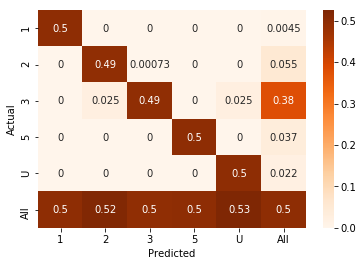

column 0 info-gain  = 0.409090
accuracy = 0.991091
column 1 info-gain  = 0.000000
accuracy = 0.991091
column 2 info-gain  = 0.306052
accuracy = 0.991091
column 3 info-gain  = 0.051344
accuracy = 0.991091
column 4 info-gain  = 0.291082
accuracy = 0.991091
column 5 info-gain  = 0.147119
accuracy = 0.991091
column 6 info-gain  = 0.213723
accuracy = 0.991091
column 7 info-gain  = 0.292235
accuracy = 0.991091
column 8 info-gain  = 0.126166
accuracy = 0.991091
column 9 info-gain  = 0.141074
accuracy = 0.991091
column 10 info-gain  = 0.032488
accuracy = 0.991091
column 11 info-gain  = 0.435178
accuracy = 0.991091
column 12 info-gain  = 0.038702
accuracy = 0.991091
column 13 info-gain  = 0.000438
accuracy = 0.991091
column 14 info-gain  = 0.039356
accuracy = 0.991091
column 15 info-gain  = 0.021775
accuracy = 0.991091
column 16 info-gain  = 0.037997
accuracy = 0.991091
column 17 info-gain  = 0.036703
accuracy = 0.991091
column 18 info-gain  = 0.000000
accuracy = 0.991091
column 19 info-gain  =

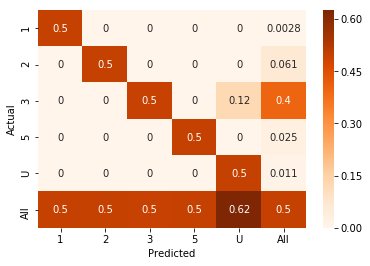

supervised Naive Bayes accuracy using holdout : 99.444444%


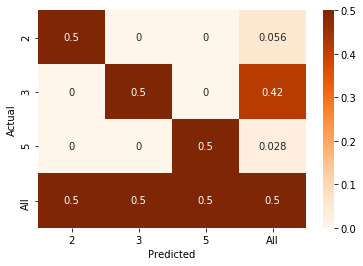

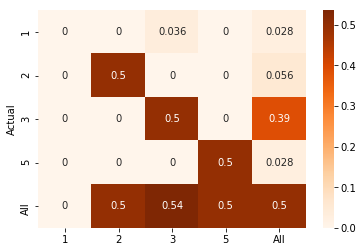

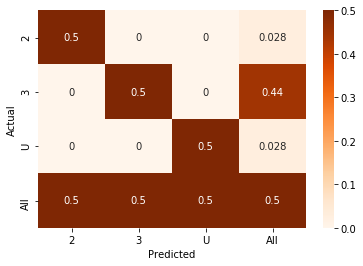

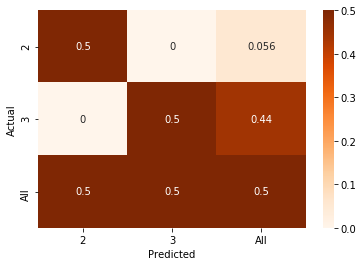

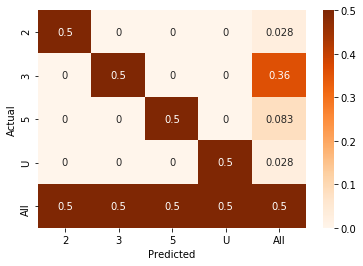

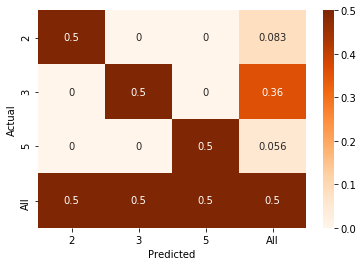

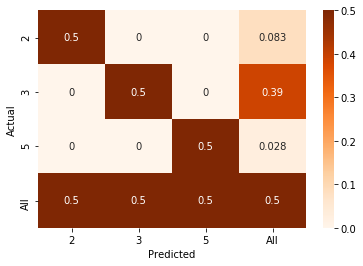

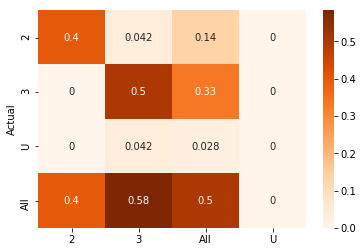

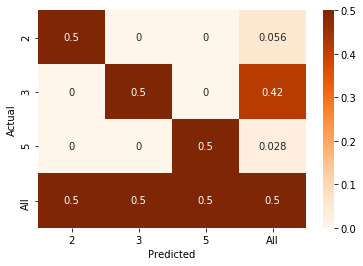

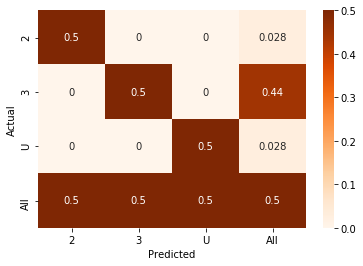

supervised Naive Bayes accuracy using cross-validation : 98.333333% 
*******************************************
Filename: breast-cancer.csv


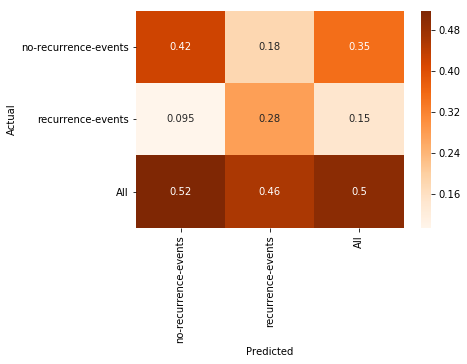

column 0 info-gain  = 0.010606
accuracy = 0.758741
column 1 info-gain  = 0.002002
accuracy = 0.758741
column 2 info-gain  = 0.057171
accuracy = 0.758741
column 3 info-gain  = 0.068995
accuracy = 0.758741
column 4 info-gain  = 0.051361
accuracy = 0.758741
column 5 info-gain  = 0.077010
accuracy = 0.758741
column 6 info-gain  = 0.002489
accuracy = 0.758741
column 7 info-gain  = 0.009339
accuracy = 0.758741
column 8 info-gain  = 0.025819
accuracy = 0.758741


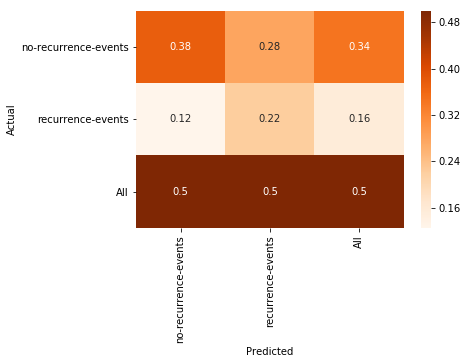

supervised Naive Bayes accuracy using holdout : 65.517241%


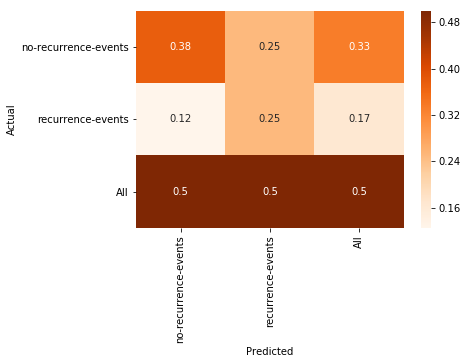

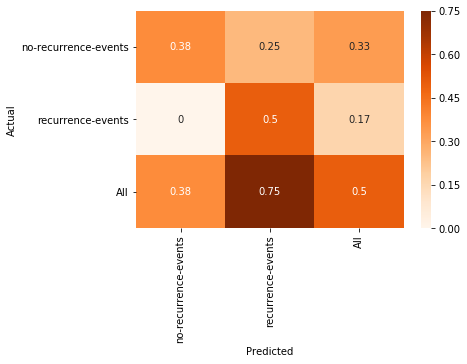

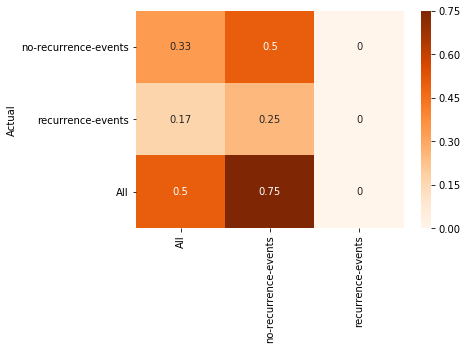

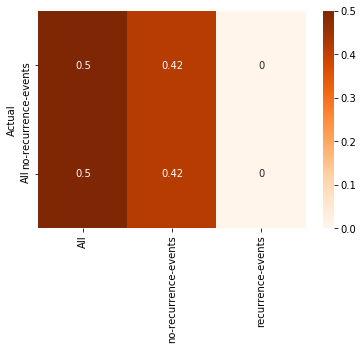

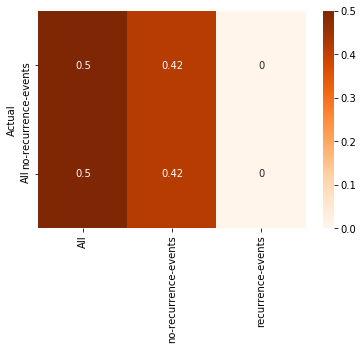

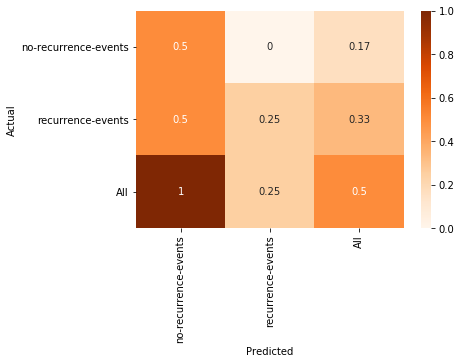

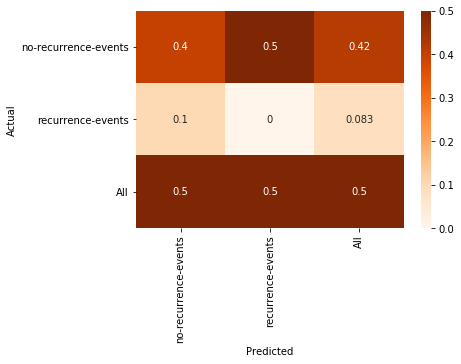

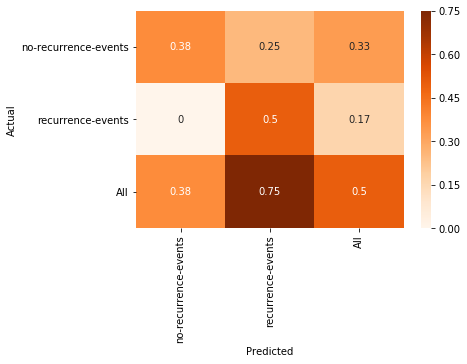

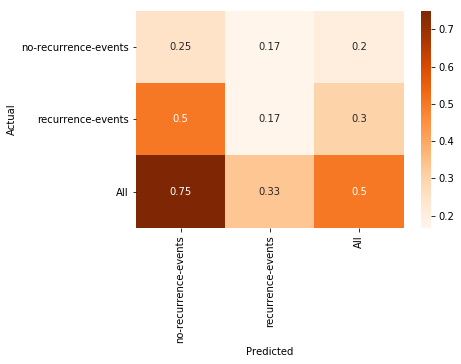

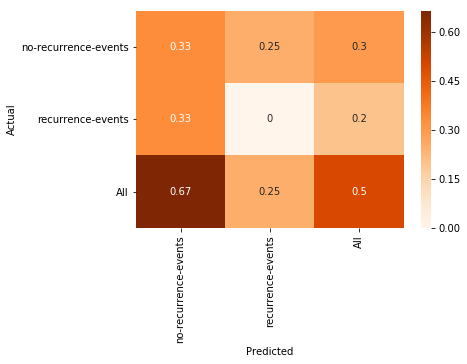

supervised Naive Bayes accuracy using cross-validation : 68.000000% 
*******************************************
Filename: car.csv


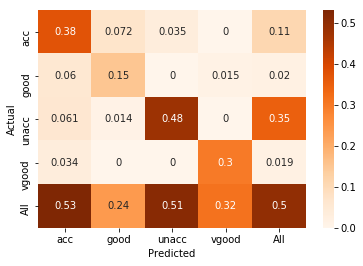

column 0 info-gain  = 0.096449
accuracy = 0.873843
column 1 info-gain  = 0.073704
accuracy = 0.873843
column 2 info-gain  = 0.004486
accuracy = 0.873843
column 3 info-gain  = 0.219663
accuracy = 0.873843
column 4 info-gain  = 0.030008
accuracy = 0.873843
column 5 info-gain  = 0.262184
accuracy = 0.873843


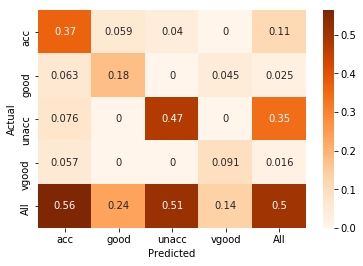

supervised Naive Bayes accuracy using holdout : 84.682081%


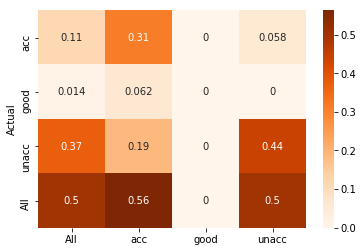

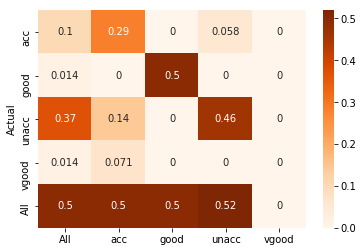

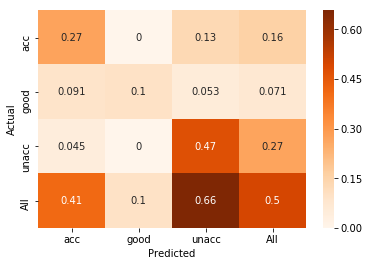

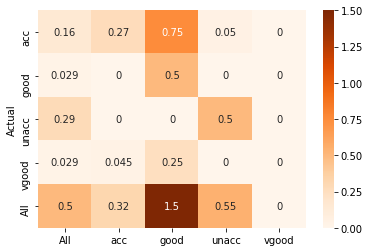

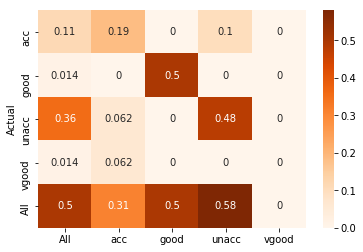

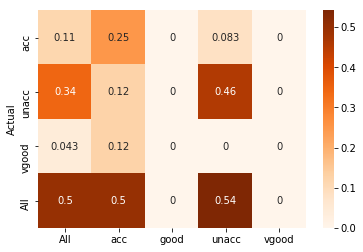

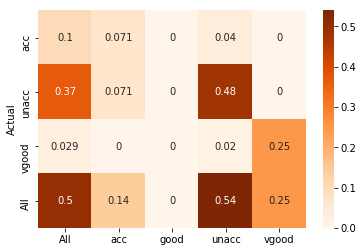

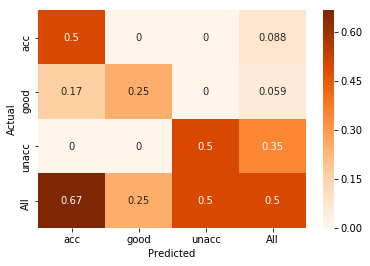

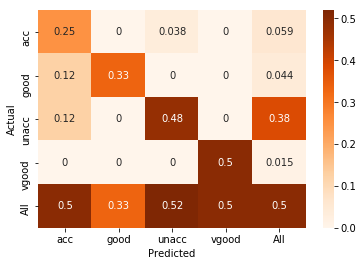

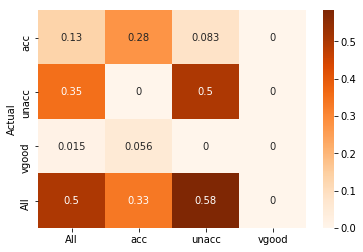

supervised Naive Bayes accuracy using cross-validation : 81.268908% 
*******************************************
Filename: cmc.csv


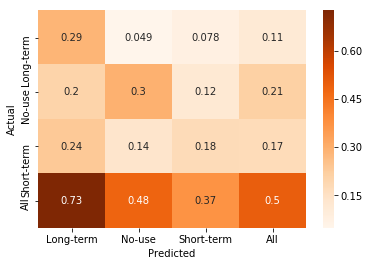

column 0 info-gain  = 0.070906
accuracy = 0.505771
column 1 info-gain  = 0.040139
accuracy = 0.505771
column 2 info-gain  = 0.101740
accuracy = 0.505771
column 3 info-gain  = 0.009821
accuracy = 0.505771
column 4 info-gain  = 0.002582
accuracy = 0.505771
column 5 info-gain  = 0.030474
accuracy = 0.505771
column 6 info-gain  = 0.032511
accuracy = 0.505771
column 7 info-gain  = 0.015786
accuracy = 0.505771


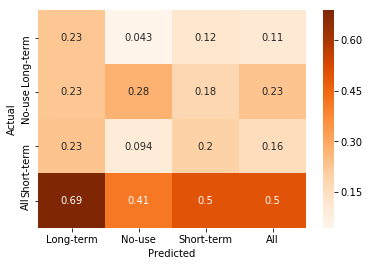

supervised Naive Bayes accuracy using holdout : 48.135593%


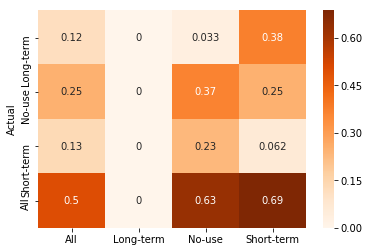

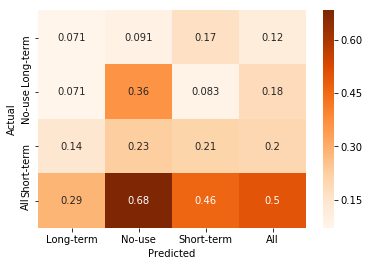

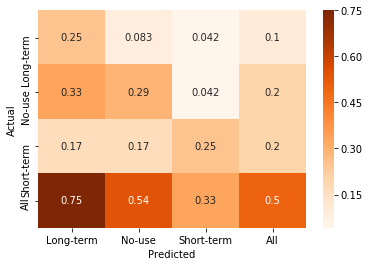

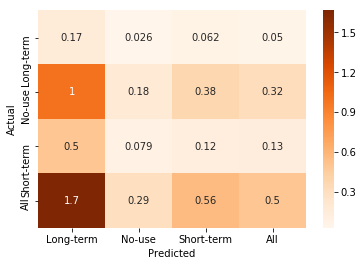

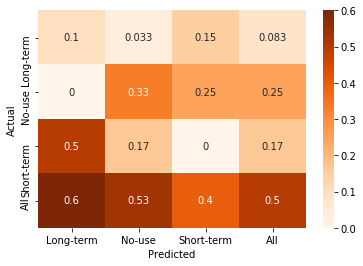

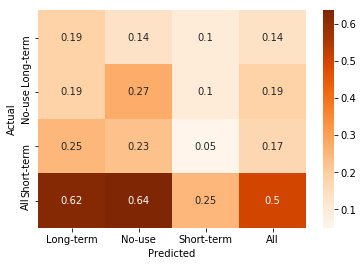

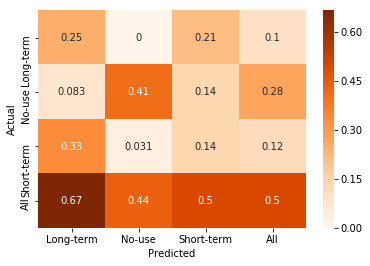

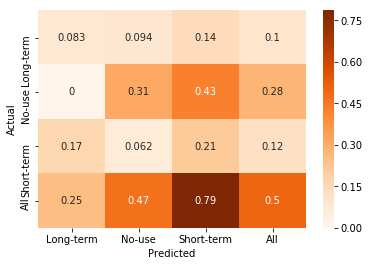

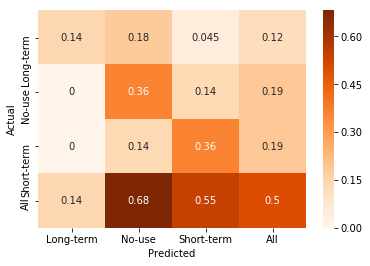

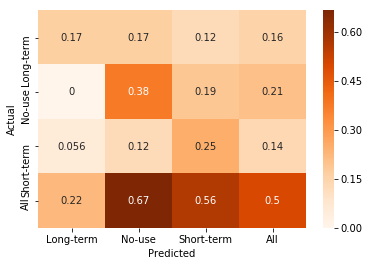

supervised Naive Bayes accuracy using cross-validation : 47.206897% 
*******************************************
Filename: hepatitis.csv


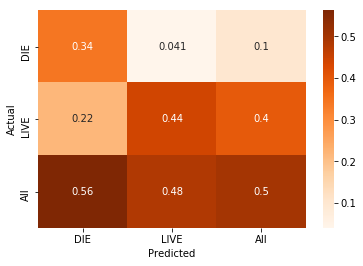

column 0 info-gain  = 0.036607
accuracy = 0.845161
column 1 info-gain  = 0.013721
accuracy = 0.845161
column 2 info-gain  = 0.014491
accuracy = 0.845161
column 3 info-gain  = 0.083151
accuracy = 0.845161
column 4 info-gain  = 0.082286
accuracy = 0.845161
column 5 info-gain  = 0.011964
accuracy = 0.845161
column 6 info-gain  = 0.007026
accuracy = 0.845161
column 7 info-gain  = 0.000289
accuracy = 0.845161
column 8 info-gain  = 0.035179
accuracy = 0.845161
column 9 info-gain  = 0.103678
accuracy = 0.845161
column 10 info-gain  = 0.127519
accuracy = 0.845161
column 11 info-gain  = 0.076456
accuracy = 0.845161
column 12 info-gain  = 0.084933
accuracy = 0.845161


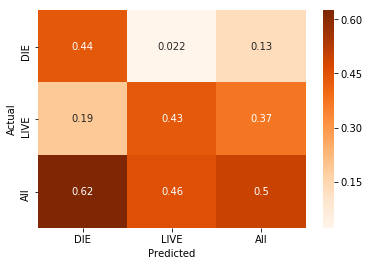

supervised Naive Bayes accuracy using holdout : 87.096774%


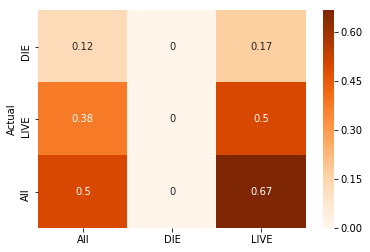

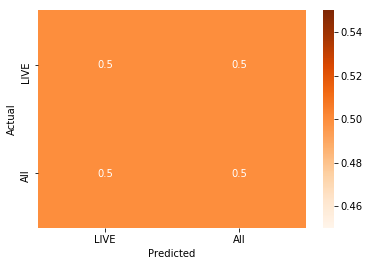

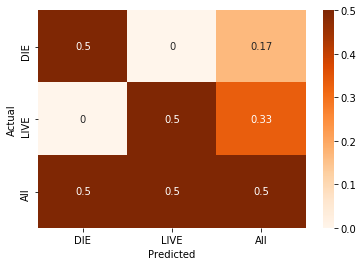

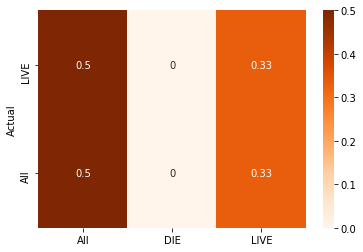

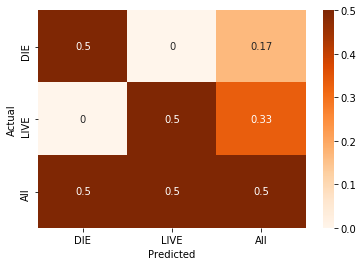

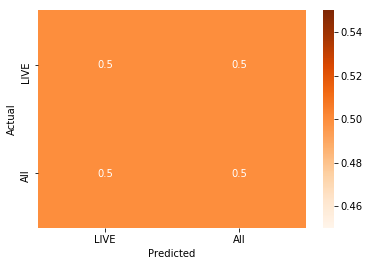

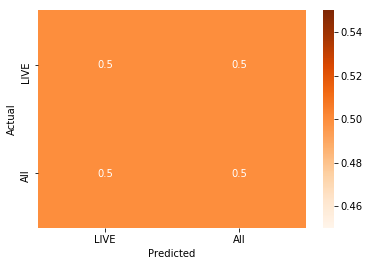

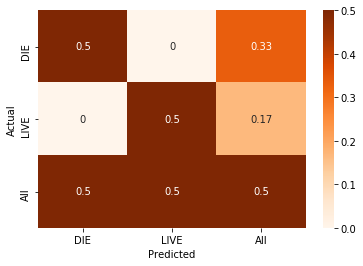

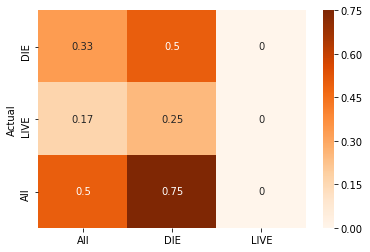

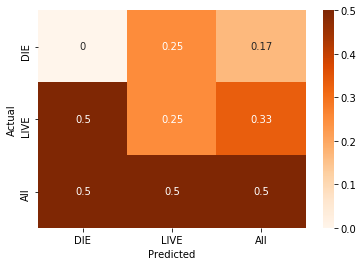

supervised Naive Bayes accuracy using cross-validation : 84.166667% 
*******************************************
Filename: hypothyroid.csv


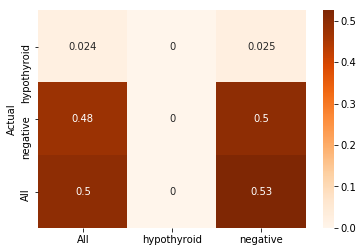

column 0 info-gain  = 0.000227
accuracy = 0.952261
column 1 info-gain  = 0.000914
accuracy = 0.952261
column 2 info-gain  = 0.001238
accuracy = 0.952261
column 3 info-gain  = 0.000148
accuracy = 0.952261
column 4 info-gain  = 0.000999
accuracy = 0.952261
column 5 info-gain  = 0.001368
accuracy = 0.952261
column 6 info-gain  = 0.000542
accuracy = 0.952261
column 7 info-gain  = 0.000435
accuracy = 0.952261
column 8 info-gain  = 0.000489
accuracy = 0.952261
column 9 info-gain  = 0.000898
accuracy = 0.952261
column 10 info-gain  = 0.000045
accuracy = 0.952261
column 11 info-gain  = 0.000079
accuracy = 0.952261
column 12 info-gain  = 0.009354
accuracy = 0.952261
column 13 info-gain  = 0.004075
accuracy = 0.952261
column 14 info-gain  = 0.005793
accuracy = 0.952261
column 15 info-gain  = 0.005768
accuracy = 0.952261
column 16 info-gain  = 0.005744
accuracy = 0.952261
column 17 info-gain  = 0.002580
accuracy = 0.952261


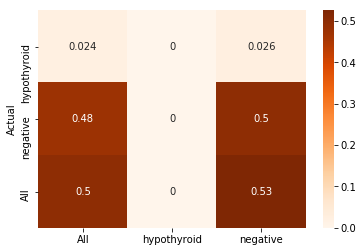

supervised Naive Bayes accuracy using holdout : 95.102686%


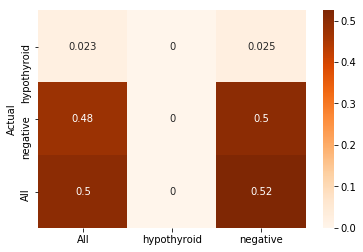

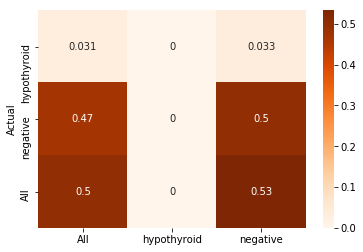

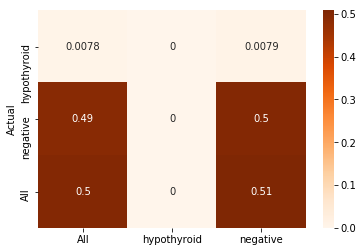

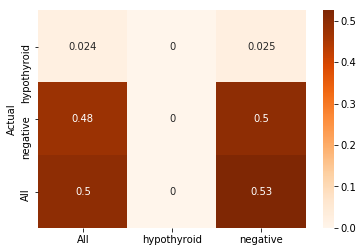

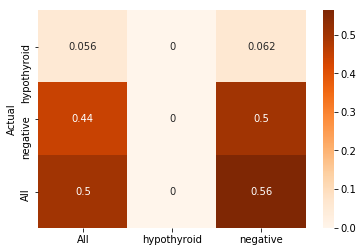

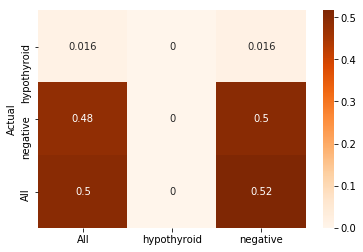

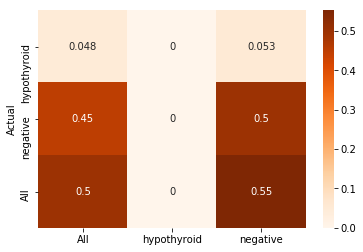

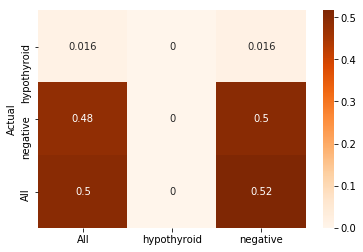

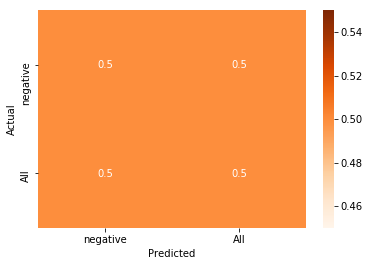

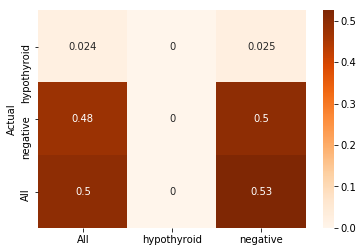

supervised Naive Bayes accuracy using cross-validation : 95.099206% 
*******************************************
Filename: mushroom.csv


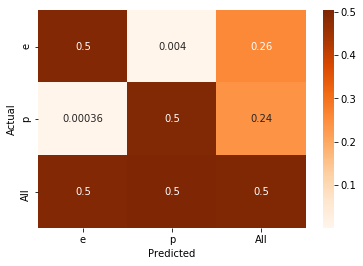

column 0 info-gain  = 0.048797
accuracy = 0.995815
column 1 info-gain  = 0.028590
accuracy = 0.995815
column 2 info-gain  = 0.036049
accuracy = 0.995815
column 3 info-gain  = 0.192379
accuracy = 0.995815
column 4 info-gain  = 0.906075
accuracy = 0.995815
column 5 info-gain  = 0.014165
accuracy = 0.995815
column 6 info-gain  = 0.100883
accuracy = 0.995815
column 7 info-gain  = 0.230154
accuracy = 0.995815
column 8 info-gain  = 0.416978
accuracy = 0.995815
column 9 info-gain  = 0.007517
accuracy = 0.995815
column 10 info-gain  = 0.108349
accuracy = 0.995815
column 11 info-gain  = 0.284726
accuracy = 0.995815
column 12 info-gain  = 0.271894
accuracy = 0.995815
column 13 info-gain  = 0.253845
accuracy = 0.995815
column 14 info-gain  = 0.241416
accuracy = 0.995815
column 15 info-gain  = -0.000000
accuracy = 0.995815
column 16 info-gain  = 0.023817
accuracy = 0.995815
column 17 info-gain  = 0.038453
accuracy = 0.995815
column 18 info-gain  = 0.318022
accuracy = 0.995815
column 19 info-gain  

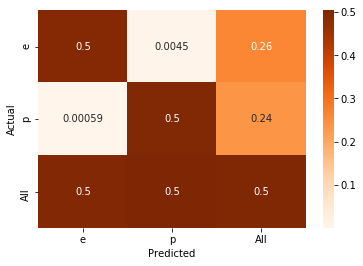

supervised Naive Bayes accuracy using holdout : 99.507692%


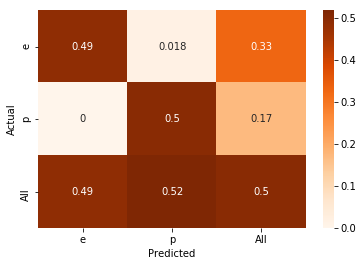

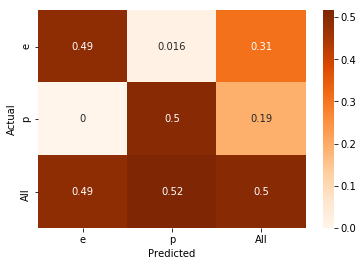

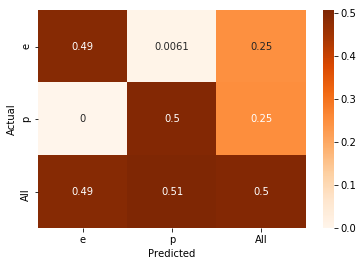

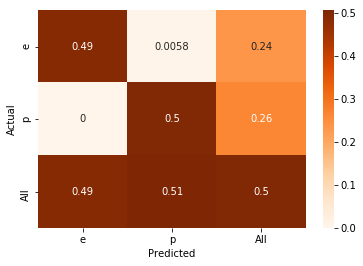

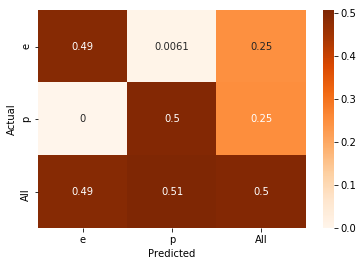

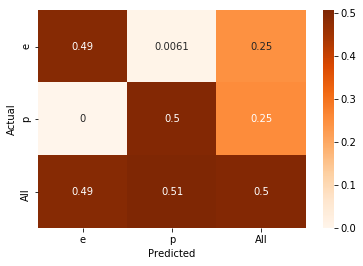

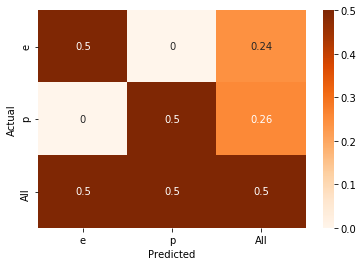

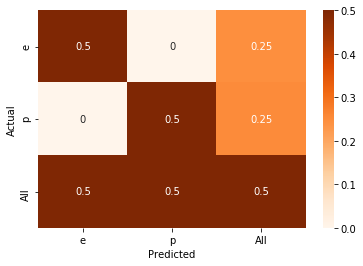

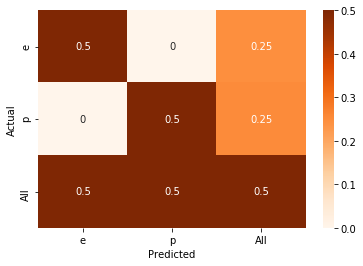

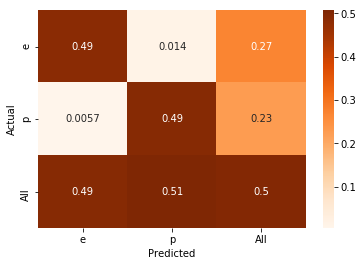

supervised Naive Bayes accuracy using cross-validation : 99.323639% 
*******************************************
Filename: nursery.csv


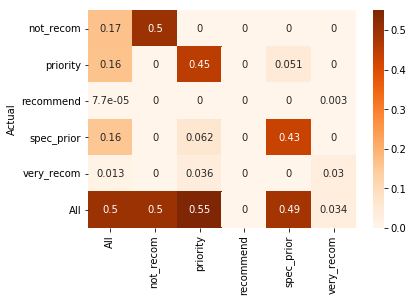

column 0 info-gain  = 0.072935
accuracy = 0.903086
column 1 info-gain  = 0.196449
accuracy = 0.903086
column 2 info-gain  = 0.005573
accuracy = 0.903086
column 3 info-gain  = 0.011886
accuracy = 0.903086
column 4 info-gain  = 0.019602
accuracy = 0.903086
column 5 info-gain  = 0.004333
accuracy = 0.903086
column 6 info-gain  = 0.022233
accuracy = 0.903086
column 7 info-gain  = 0.958775
accuracy = 0.903086


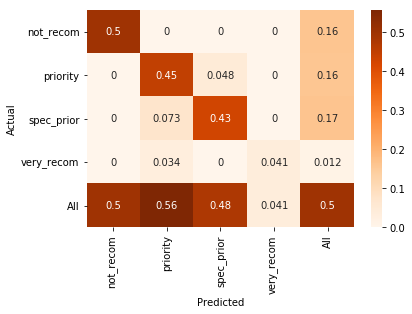

supervised Naive Bayes accuracy using holdout : 89.930556%


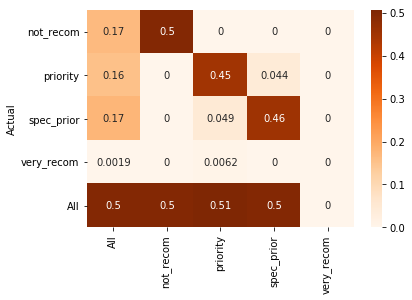

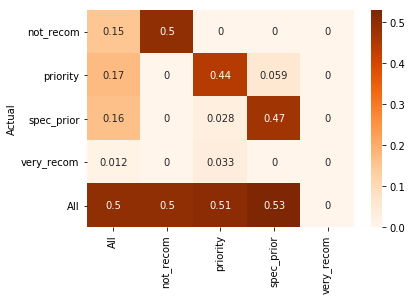

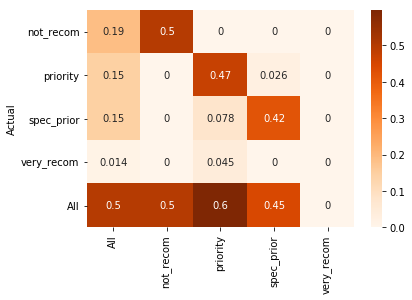

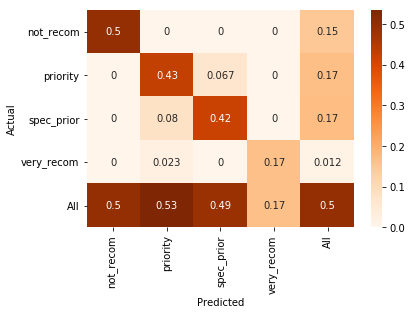

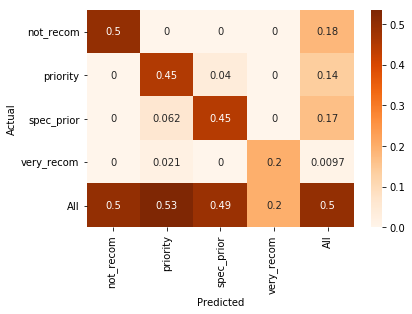

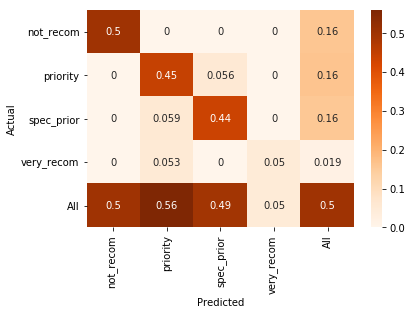

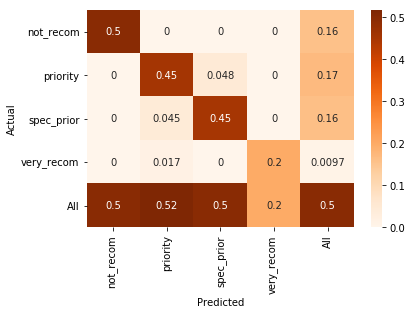

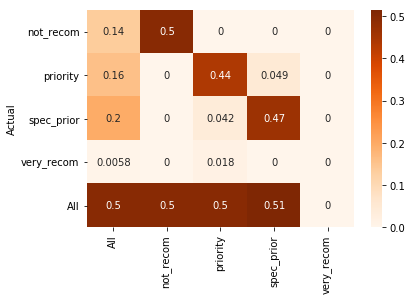

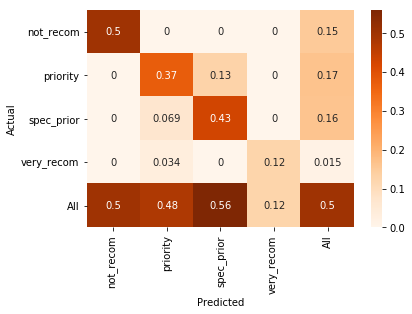

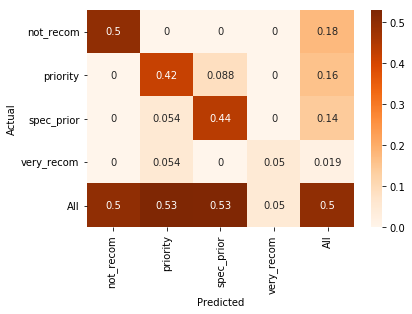

supervised Naive Bayes accuracy using cross-validation : 90.430353% 
*******************************************
Filename: primary-tumor.csv


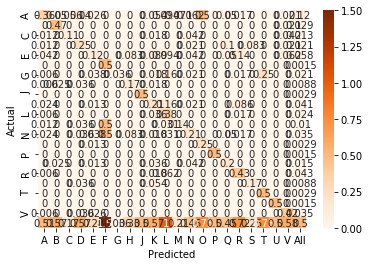

column 0 info-gain  = 0.154742
accuracy = 0.575221
column 1 info-gain  = 0.322899
accuracy = 0.575221
column 2 info-gain  = 0.310375
accuracy = 0.575221
column 3 info-gain  = 0.199206
accuracy = 0.575221
column 4 info-gain  = 0.212462
accuracy = 0.575221
column 5 info-gain  = 0.020367
accuracy = 0.575221
column 6 info-gain  = 0.100881
accuracy = 0.575221
column 7 info-gain  = 0.067873
accuracy = 0.575221
column 8 info-gain  = 0.220522
accuracy = 0.575221
column 9 info-gain  = 0.199761
accuracy = 0.575221
column 10 info-gain  = 0.067145
accuracy = 0.575221
column 11 info-gain  = 0.054014
accuracy = 0.575221
column 12 info-gain  = 0.291530
accuracy = 0.575221
column 13 info-gain  = 0.127154
accuracy = 0.575221
column 14 info-gain  = 0.240106
accuracy = 0.575221
column 15 info-gain  = 0.184258
accuracy = 0.575221
column 16 info-gain  = 0.170148
accuracy = 0.575221


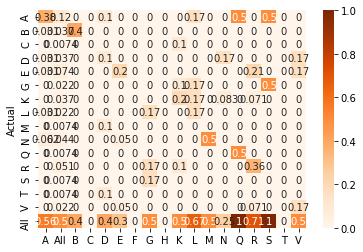

supervised Naive Bayes accuracy using holdout : 45.588235%


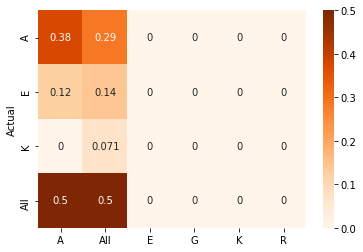

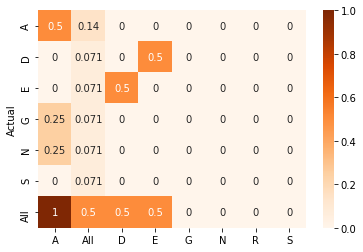

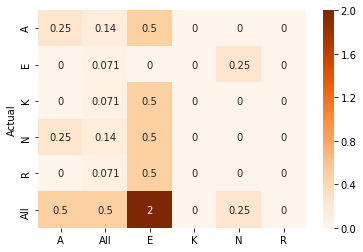

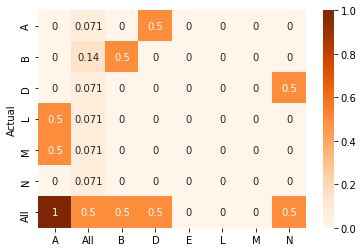

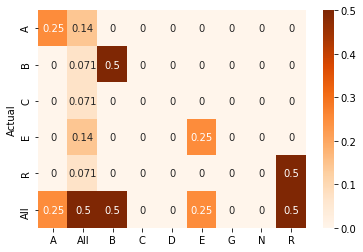

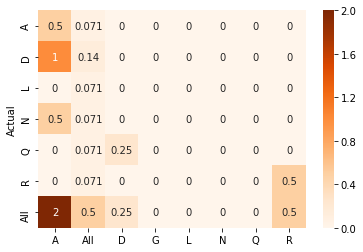

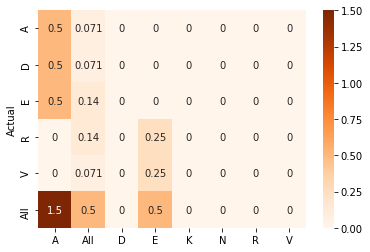

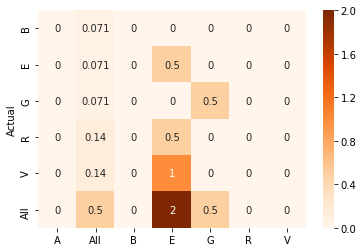

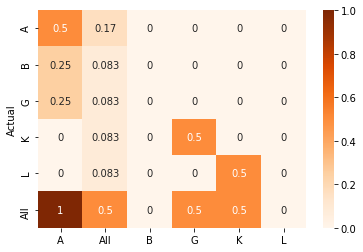

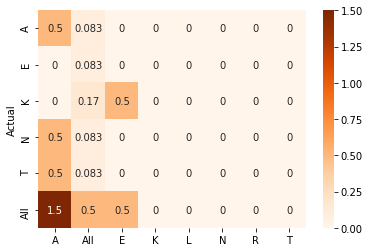

supervised Naive Bayes accuracy using cross-validation : 29.285714% 
*******************************************


In [19]:

def main():
    
    
    path = '2019S1-proj1-data_dos/'
    extension = 'csv'
    datasets = get_datasets(path,extension) # fetch data
    
    print("*******************************************")
    
    for file in datasets:
        
        data = preprocessing(file) # perform preprocessing
        
        print('Filename: %s' % file) 
        
        group_data_by_cols_dic = group_data_by_cols(data) # get the dictionary of list of probabilities of instances by attribute column that 
                                                          # corresponds to a class
    
        prior_probability,posterior_probability = train(data) # train data
        
        evaluate_score  = evaluate(prior_probability, posterior_probability, data) # calculate scores
    
        class_entropy = entropy_of_class(prior_probability) # total class entropy attained
    
        probabilities_dict = prob_attributes(data) # map of probabilites of each instance for 
                                                   # a given attribute 
    
        # handy technique to get non repeated columns
        columns  = sorted(set(j for i in posterior_probability.keys() for j in posterior_probability[i].keys())) 
        
                 
        for column in columns:
            # print and calculate info gain for each column with respect to class labels
            info_gain = information_gain(group_data_by_cols_dic,column, class_entropy,probabilities_dict)
            print("column %d info-gain  = %f" %(column,info_gain))
            print("accuracy = %f" %(evaluate_score))
        
        hold_out = (holdout(data,0.8))*100 # find holdout accuracy score
        
        print('supervised Naive Bayes accuracy using holdout : %f%%' % (hold_out)) 
            
        cross_valid = cross_validation(data, 10)*100  # find cross-validation accuracy score
        
        print('supervised Naive Bayes accuracy using cross-validation : %f%% ' % (cross_valid))
        
        print("*******************************************") 
        
        
if __name__ == '__main__':
    main()

Questions (you may respond in a cell or cells below):

1. The Naive Bayes classifiers can be seen to vary, in terms of their effectiveness on the given datasets (e.g. in terms of Accuracy). Consider the Information Gain of each attribute, relative to the class distribution — does this help to explain the classifiers’ behaviour? Identify any results that are particularly surprising, and explain why they occur.
2. The Information Gain can be seen as a kind of correlation coefficient between a pair of attributes: when the gain is low, the attribute values are uncorrelated; when the gain is high, the attribute values are correlated. In supervised ML, we typically calculate the Infomation Gain between a single attribute and the class, but it can be calculated for any pair of attributes. Using the pair-wise IG as a proxy for attribute interdependence, in which cases are our NB assumptions violated? Describe any evidence (or indeed, lack of evidence) that this is has some effect on the effectiveness of the NB classifier.
3. Since we have gone to all of the effort of calculating Infomation Gain, we might as well use that as a criterion for building a “Decision Stump” (1-R classifier). How does the effectiveness of this classifier compare to Naive Bayes? Identify one or more cases where the effectiveness is notably different, and explain why.
4. Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy. How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)
5. Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the Naive Bayes classifier? Explain why, or why not.
6. Naive Bayes is said to elegantly handle missing attribute values. For the datasets with missing values, is there any evidence that the performance is different on the instances with missing values, compared to the instances where all of the values are present? Does it matter which, or how many values are missing? Would a imputation strategy have any effect on this?

Don't forget that groups of 1 student should respond to question (1), and one other question of your choosing. Groups of 2 students should respond to question (1) and question (2), and two other questions of your choosing. Your responses should be about 150-250 words each.

# Question 1

The statistics of all the 9 datasets can be seen above. In general, it is quite visual that the __accuracy scores for the Naive Bayes model for the dataset is positively correlated to the information gain in the dataset__. There might be some over estimates due to chosing the most common item replacement technique to the noisy data.(All values given are maximum respective values)

In general, if we look into statistics individually we observed that the _anneal.csv_ and _mushroom.csv_ perform brilliantly with the Naive Bayes classifier. The dataset in _mushroom.csv_ performed the best and had high IG values (<font color = blue>column 8</font> info-gain  = <font color = red> 0.416978 </font> and <font color = blue> column 4 </font> info-gain  =  <font color = red> 0.906075 </font>) with an accuracy score of <font color = red> 0.995815 </font>. The dataset _anneal.csv_, _car.csv_, _nursery.csv_ had attributes with respective Information Gains of <font color = blue> 0.435178 , 0.262184 , 0.958775 </font> with respective accuracies <font color = red> 0.991091 , 0.873843 , 0.873843 </font> with higher end values in the True Positive and True Negative forming clear clusters (higher end of density values) compared to False Negative and False Positive regions respectively for the highest IG values. On the other hand, the Information Gain for _breast-cancer.csv_ and _cmc.csv_ was relatively low with respectively being <font color = blue> 0.077010 , 0.101740 </font> leading to the respective accuracies <font color = blue> 0.758741, 0.505771 </font> with lower values (lower end of density) in the True Positive and True Negative compared to False Negative and False Positive regions respectively for the highest IG values.

However, we did come up with some interesting observations as well. If we look closely into _hypothyroid.csv_, even though there were some low information gain values in the range <font color = blue> 0.000045 ,  -0.009354 </font> ended up with very high accuracy score of <font color = red> 0.952261 </font>. If we clearly look at the clusters in the confusion matrix there are higher value in the TN region relative to others contributing to higher accuracies. At a closer look at the output, we noticed __all the instances are predicted as "negative" class , just like a zero - R classifier__ (zero- R being a baseline making Naive Bayes of no use) and outcome shares "negative" classes, making them indistinguishable giving not enough information about effectiveness.

Finally, we found another interesting result with _primary-tumor.csv_ has high attributes with relative high information gain values of <font color   = blue> 0.322899 , 0.310375 </font> but the classifier comes up with low score of <font color  = red> 0.575221 </font>. If we closely look into the reasons for such result, I presume the datasize was relatively small (only around 339 instances) that creates some biases which makes some of the confusion matrices for the attribute column be not well clustered. The other reason might be that the decision making might not depend on the higher attributes with high information gains.

# Question 4

As widely thought while evaluating the model using same dataset that trains the model would over fit and over estimate the accuracy as the training instances seem as the "seen" seem to pretend the outcomes are "unseen". We use both different evaluation strategies and I have used both the [hold-out evaluation strategy](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) hold-out evaluation and the [cross-validation evaluation strategy](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). The table below illustrates the accuracy instances and the accuracies of each of the techniques with constant split size of 80 % and k = 10 used that can be verified with the output above (manually inputted data by copy pasting from the above displayed answer from main).

In [55]:
# helps display better

header  = ['Dataset', 'anneal', 'breast cancer', 'car', 'cmc', 'hepatitis','hypothyroid','mushroom','nursery','primary-tumor']

accuracy = ['accuracy', '99.12%','75.87%','87.38%','50.58%','84.52%','95.22%','99.58%','90.31%','57.52%']

holdout_acc = ['hold-out accuracy','99.44%','65.52%','84.68%','48.14%','87.10%','95.10%','99.51%','89.93%','45.59%']

cross_validat_acc = ['cross-validation accuracy','98.33%','68.00%','81.27% ','47.21%','84.17%','95.10%','99.32%','90.43%','29.29%']

instances = ['instances','898','286','1728','1473','155', '3163','8124','12960','339']

results_df  = pd.DataFrame([ accuracy, holdout_acc,cross_validat_acc,instances],columns = header)
results_df

,Dataset,anneal,breast cancer,car,cmc,hepatitis,hypothyroid,mushroom,nursery,primary-tumor
0,accuracy,99.12%,75.87%,87.38%,50.58%,84.52%,95.22%,99.58%,90.31%,57.52%
1,hold-out accuracy,99.44%,65.52%,84.68%,48.14%,87.10%,95.10%,99.51%,89.93%,45.59%
2,cross-validation accuracy,98.33%,68.00%,81.27%,47.21%,84.17%,95.10%,99.32%,90.43%,29.29%
3,instances,898,286,1728,1473,155,3163,8124,12960,339


It is quite evident from the above table that the accuracy scores across __7 out 9__ of the accuracy techniques are relatively close (in the range of the values) to each other. There is hardly any over estimation with the techniques and the random shuffling in some instances in holdout finely tunes and does better in some datasets like _anneal_ and _hepatitis_ and cross-validation performs better with the low information gain attributes like _breast-cancer_. Since, the Naive Bayes is mainly probability-driven (does not overestimate) but acts in a fairly stable way if sufficient number of instances are given. We use a a train-test splitting technique to evaluate accuracy with the probabilistic model calculated from the training dataset that __has a similar probability distribution to testing dataset__, evaluation accuracy on test data will be similar to evaluation accuracy on the whole dataset. In fact, <font color  = green> cross validation </font> through its iterations uses the whole dataset to measure accuracies close to other two techniques.

In the case of _primary-tumor_ only, the model seems to overestimate as I have mentioned above for the possibility of insufficient instances and many instance values that were replaced with most common item in the attribute.
Another interesting finding is with _breast-cancer_ where the split size was <font color = red> 80% </font> with small instance size had accuracy of <font color  = red> 65.52% </font> for <font color  = orange > holdout </font>  and <font color  = red> 68.00% </font> for <font color  = orange > cross-validation </font> but after multiple runnings of the program can get around roughly <font color = brown > 80% </font> accuracy mark for both.The effectiveness of evaluation strategy using  holdout stays the same provided the instance size is sufficient. In the case of cross-validation with around roughly 15 partitions we can even come with far better results but it would be a trade-off with runtime.